In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [508]:
evds=evdsAPI('dsIC3fiGlu')


In [509]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4607,29-09-2023,27.4245
4608,02-10-2023,27.4260
4609,03-10-2023,27.4537
4610,04-10-2023,27.5013


In [510]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [511]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


In [512]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [513]:

inflation=pd.DataFrame.from_dict({'Tarih':["2023-10"],'TÜFE': [1760]})
inflation=pd.concat([enf,inflation],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


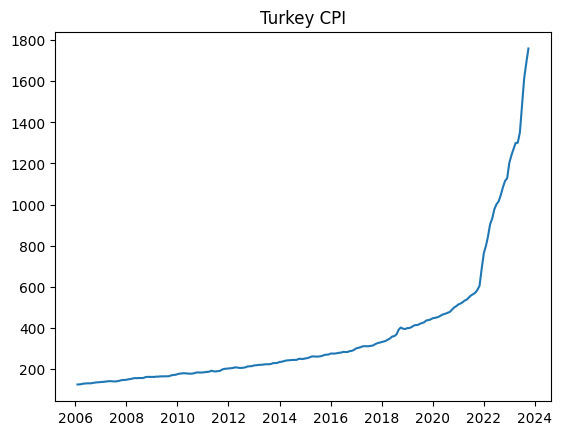

In [514]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [515]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [516]:
dates= pd.date_range('2006-02-01','2023-11-01' , freq='1M')

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6


,USD/TL,Onceki USD/TL
2006-02-28,1.326535,1.320000
2006-03-31,1.335139,1.326535
2006-04-30,1.337345,1.335139
2006-05-31,1.420659,1.337345
2006-06-30,1.600536,1.420659
...,...,...
2023-06-30,23.106042,19.719514
2023-07-31,26.470338,23.106042
2023-08-31,26.999127,26.470338
2023-09-30,26.989448,26.999127


In [517]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [518]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply=money_supply.set_index(pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money1=pd.DataFrame.from_dict({'Tarih':["2023-10"],'Para Arzi': [13095000000]})
money=pd.concat([money_supply,money1],axis=0)
money


,Tarih,Para Arzi
2006-02-01 00:00:00,2006-2,2.423895e+08
2006-03-01 00:00:00,2006-3,2.494857e+08
2006-04-01 00:00:00,2006-4,2.521919e+08
2006-05-01 00:00:00,2006-5,2.751947e+08
2006-06-01 00:00:00,2006-6,2.791388e+08
...,...,...
2023-06-01 00:00:00,2023-6,1.083453e+10
2023-07-01 00:00:00,2023-7,1.147848e+10
2023-08-01 00:00:00,2023-8,1.202532e+10
2023-09-01 00:00:00,2023-9,1.234928e+10


In [519]:
money=money.set_index(pd.date_range('2006-02-01','2023-11-01' , freq='1M'))
money["Para Arzi"]=money["Para Arzi"]/1e+08
del money["Tarih"]
money["Para Arzi Onceki"]=money["Para Arzi"].shift(1)
money=money.dropna(axis=0)
money


,Para Arzi,Para Arzi Onceki
2006-03-31,2.494857,2.423895
2006-04-30,2.521919,2.494857
2006-05-31,2.751947,2.521919
2006-06-30,2.791388,2.751947
2006-07-31,2.711670,2.791388
...,...,...
2023-06-30,108.345324,94.093167
2023-07-31,114.784753,108.345324
2023-08-31,120.253199,114.784753
2023-09-30,123.492792,120.253199


In [520]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4599,19-09-2023,96.11
4600,20-09-2023,94.56
4601,21-09-2023,93.70
4602,22-09-2023,93.99


In [521]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [522]:

brent1=pd.concat([brent,pd.DataFrame({"2023-10": [85]})],axis=0)
brent1.columns=["Brent","A"]
brent1.iloc[212,0]=85
del brent1["A"]
brent1=brent1.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
brent1

,Brent
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.182941


In [523]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\Bora\AppData\Local\Temp\ipykernel_14788\3746592372.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [524]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09


In [525]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055


In [526]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=pd.concat([df3,pd.DataFrame({"Kredi": [106.01]})],axis=0)
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

C:\Users\Bora\AppData\Local\Temp\ipykernel_14788\3817705556.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582110


In [527]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00


C:\Users\Bora\AppData\Local\Temp\ipykernel_14788\1609234707.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


Text(0.5, 1.0, 'TCMB Fonlama Faizi')

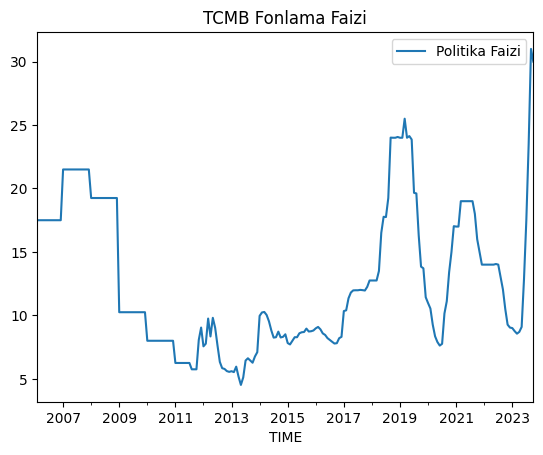

In [528]:
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz.plot(label="TCMB Fonlama Faizi")
plt.title("TCMB Fonlama Faizi")

In [529]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
kfaiz=pd.concat([kfaiz,pd.DataFrame({"Kredi Faizi": [61.83]})],axis=0)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.2980


In [530]:
X=pd.concat([df6["USD/TL"].rolling(3).mean().dropna(),money["Para Arzi Onceki"].tail(211),df14.Brent,df3.Kredi,pfaiz["Politika Faizi"],kfaiz["Kredi Faizi"]],axis=1)
X=X.dropna(axis=0)
X



,USD/TL,Para Arzi Onceki,Brent,Kredi,Politika Faizi,Kredi Faizi
2006-04-30,1.333006,2.494857,70.260000,1.527510,17.50,16.2075
2006-05-31,1.364381,2.521919,69.776957,1.664881,17.50,16.3000
2006-06-30,1.452847,2.751947,68.555909,1.740395,17.50,19.6700
2006-07-31,1.526487,2.791388,73.674286,1.731811,17.50,25.2825
2006-08-31,1.542683,2.711670,73.230435,1.742468,17.50,25.5075
...,...,...,...,...,...,...
2023-06-30,20.720863,94.093167,74.839091,95.646045,12.84,38.5600
2023-07-31,23.098631,108.345324,80.108095,98.468952,17.50,45.8250
2023-08-31,25.525169,114.784753,86.147727,99.238055,23.50,45.7650
2023-09-30,26.819638,120.253199,93.182941,102.582110,31.00,56.2980


In [531]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y=y.tail(211)
y=y.set_index(X.index)
y


,CPI
2006-04-30,125.84
2006-05-31,128.20
2006-06-30,128.63
2006-07-31,129.72
2006-08-31,129.15
...,...
2023-06-30,1351.59
2023-07-31,1479.84
2023-08-31,1614.31
2023-09-30,1691.04


In [532]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [533]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

# Modelin özetini görüntüleyin
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     7302.
Date:                Thu, 05 Oct 2023   Prob (F-statistic):          4.21e-172
Time:                        21:31:09   Log-Likelihood:                -623.00
No. Observations:                 147   AIC:                             1260.
Df Residuals:                     140   BIC:                             1281.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               79.5350      7.800  

In [534]:
results.params

const               79.535017
USD/TL              13.722701
Para Arzi Onceki     7.182348
Brent                0.194442
Kredi                2.736626
Politika Faizi      -1.507922
Kredi Faizi          1.562408
dtype: float64

In [535]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
train_data = df6['USD/TL'].rolling(3).mean().dropna()[:len(df6.rolling(3).mean().dropna())-12]
test_data = df6['USD/TL'].rolling(3).mean().dropna()[len(df6.rolling(3).mean().dropna())-12:]


ar_model = AutoReg(df6['USD/TL'].rolling(3).mean().dropna(), lags=1)
ar_fit = ar_model.fit()
ar_forecast = ar_fit.predict(start="2023-11-30", end="2024-10-30", dynamic=False)
ar_forecast




2023-11-30    28.244245
2023-12-31    29.375085
2024-01-31    30.554205
2024-02-29    31.783668
2024-03-31    33.065622
2024-04-30    34.402308
2024-05-31    35.796063
2024-06-30    37.249324
2024-07-31    38.764631
2024-08-31    40.344633
2024-09-30    41.992092
2024-10-31    43.709889
Freq: M, dtype: float64

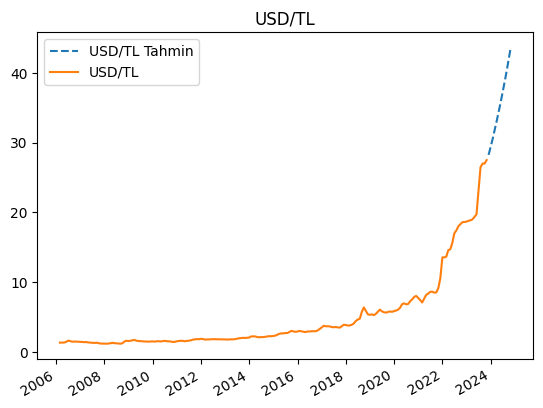

In [536]:
usdtahmin=pd.DataFrame(ar_forecast)
usdtahmin.columns=["USD Tahmin"]
usdtahmin["USD Tahmin"]=usdtahmin["USD Tahmin"].astype(float)
usdtahmin=usdtahmin.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
plt.plot(usdtahmin,"--",label="USD/TL Tahmin")
df6["USD/TL"].plot(label="USD/TL")
plt.title("USD/TL")
plt.legend()


c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Bora\AppD

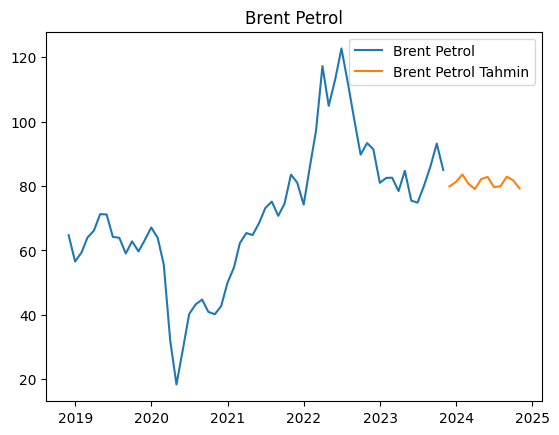

In [537]:
# Modeli eğitim verisi üzerinde eğitme
model = ARIMA(df14["Brent"], order=(4,1,2))
# Modeli tekrar eğitim verisi üzerinde eğitme
model_fit = model.fit()

# Tahmin yapma
forecast = model_fit.forecast(steps=12)
predictions = forecast.values
predictions = pd.DataFrame(predictions,index=pd.date_range('2023-10-01', periods=12, freq='M'))
brenttahmin=pd.DataFrame(predictions)
brenttahmin.columns=["Brent Tahmin"]
brenttahmin=brenttahmin.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
plt.plot(df14.tail(60),label="Brent Petrol")
plt.plot(brenttahmin.tail(60),label="Brent Petrol Tahmin")
plt.title("Brent Petrol")
plt.legend()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


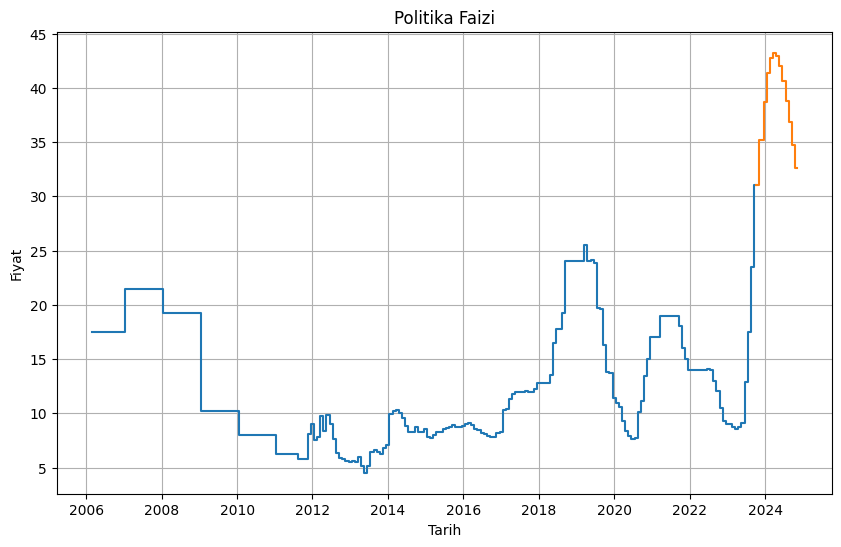

In [538]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(pfaiz.head(212), order=(4,1,1))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-11-01', periods=12, freq='M'))

faiztahmin=pd.DataFrame(optimal_future_predictions)
faiztahmin.columns=["Politika Faizi"]
faiztahmin=faiztahmin.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
faiztahmin=pd.concat([pfaiz.head(212),faiztahmin],axis=0)
kademeli = [faiztahmin.iloc[0]]
for i in range(1, len(faiztahmin)):
    kademeli.append(faiztahmin.iloc[i])

# Tarihleri x ekseni olarak ve kademeli fiyatları y ekseni olarak kullanarak kademeli bir grafik çiz
plt.figure(figsize=(10, 6))
plt.step(faiztahmin[:212].index, kademeli[:212], where='mid', linestyle='-')
plt.step(faiztahmin[211:].index, kademeli[211:], where='mid', linestyle='-')
plt.title('Politika Faizi')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.grid(True)


In [539]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(money["Para Arzi Onceki"], order=(4,3,4))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-11-01', periods=12, freq='M'))
paraarzitahmin=pd.DataFrame(optimal_future_predictions)
paraarzitahmin.columns=["Para Arzı Tahmin"]
paraarzitahmin=paraarzitahmin.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
paraarzitahmin=paraarzitahmin.tail(12)
paraarzitahmin


c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Para Arzı Tahmin
2023-11-30,130.959261
2023-12-31,133.777242
2024-01-31,142.641794
2024-02-29,145.650574
2024-03-31,154.961519
2024-04-30,158.763721
2024-05-31,168.204581
2024-06-30,172.875688
2024-07-31,182.494022
2024-08-31,187.942883


In [540]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(df3["Kredi"], order=(4,3,4))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-11-01', periods=12, freq='M'))
kreditahmin=pd.DataFrame(optimal_future_predictions)
kreditahmin.columns=["Kredi Tahmin"]
kreditahmin=kreditahmin.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
kreditahmin=kreditahmin.tail(12)
kreditahmin

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Kredi Tahmin
2023-11-30,108.300049
2023-12-31,112.138013
2024-01-31,115.888641
2024-02-29,118.029698
2024-03-31,121.471160
2024-04-30,125.639979
2024-05-31,128.032541
2024-06-30,131.043983
2024-07-31,135.415141
2024-08-31,138.216639


In [541]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(kfaiz["Kredi Faizi"], order=(1,1,0))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-11-01', periods=12, freq='M'))
optimal_future_predictions.columns=["Kredi Faizi Tahmin"]



kfaiztahmin=pd.DataFrame(optimal_future_forecast)
kfaiztahmin=kfaiztahmin.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
kfaiztahmin.columns=["Kredi Faizi Tahmin"]
kfaiztahmin=kfaiztahmin.tail(12)
kfaiztahmin

,Kredi Faizi Tahmin
2023-11-30,64.736066
2023-12-31,66.262679
2024-01-31,67.064637
2024-02-29,67.485922
2024-03-31,67.707231
2024-04-30,67.823489
2024-05-31,67.884561
2024-06-30,67.916644
2024-07-31,67.933497
2024-08-31,67.942351


In [542]:
tahmindf=pd.DataFrame()
tahmindf["USD Tahmin"]=usdtahmin["USD Tahmin"]
tahmindf["Brent Tahmin"]=brenttahmin["Brent Tahmin"]
tahmindf["Politika Faizi Tahmin"]=faiztahmin["Politika Faizi"]
tahmindf["Para Arzı Tahmin"]=paraarzitahmin["Para Arzı Tahmin"]
tahmindf["Kredi Tahmin"]=kreditahmin["Kredi Tahmin"]
tahmindf["Kredi Faizi Tahmin"]=kfaiztahmin["Kredi Faizi Tahmin"]
tahmindf=tahmindf.set_index(pd.date_range('2023-11-01','2024-11-01' , freq='1M'))
tahmindf

,USD Tahmin,Brent Tahmin,Politika Faizi Tahmin,Para Arzı Tahmin,Kredi Tahmin,Kredi Faizi Tahmin
2023-11-30,28.244245,79.877225,35.213897,130.959261,108.300049,64.736066
2023-12-31,29.375085,81.285367,38.726700,133.777242,112.138013,66.262679
2024-01-31,30.554205,83.560983,41.393153,142.641794,115.888641,67.064637
2024-02-29,31.783668,80.735103,42.734110,145.650574,118.029698,67.485922
2024-03-31,33.065622,79.072205,43.237055,154.961519,121.471160,67.707231
2024-04-30,34.402308,82.156078,42.978736,158.763721,125.639979,67.823489
2024-05-31,35.796063,82.834365,42.037924,168.204581,128.032541,67.884561
2024-06-30,37.249324,79.670377,40.612403,172.875688,131.043983,67.916644
2024-07-31,38.764631,79.919225,38.832044,182.494022,135.415141,67.933497
2024-08-31,40.344633,82.881114,36.822212,187.942883,138.216639,67.942351


C:\Users\Bora\AppData\Local\Temp\ipykernel_14788\1267071032.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res2.append(results.params["const"]+results.params["USD/TL"]*tahmindf["USD Tahmin"].iloc[i]+results.params["Para Arzi Onceki"]*tahmindf["Para Arzı Tahmin"].iloc[i]+results.params["Kredi"]*tahmindf["Kredi Tahmin"].iloc[i]+results.params["Brent"]*tahmindf["Brent Tahmin"].iloc[i]+results.params["Politika Faizi"]*tahmindf["Politika Faizi Tahmin"].iloc[i]+results.params["Kredi Faizi"]*tahmindf["Kredi Faizi Tahmin"][i])


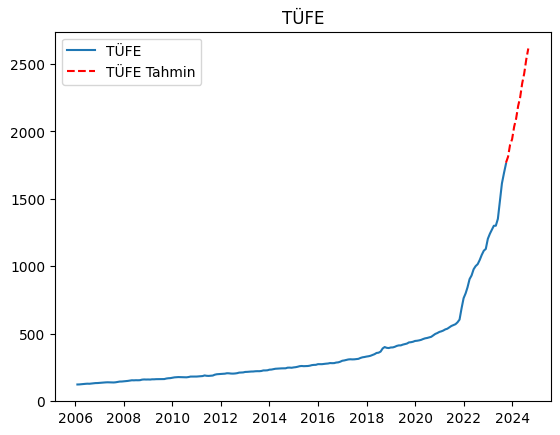

In [543]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

res2=[]



for i in range(12):
    res2.append(results.params["const"]+results.params["USD/TL"]*tahmindf["USD Tahmin"].iloc[i]+results.params["Para Arzi Onceki"]*tahmindf["Para Arzı Tahmin"].iloc[i]+results.params["Kredi"]*tahmindf["Kredi Tahmin"].iloc[i]+results.params["Brent"]*tahmindf["Brent Tahmin"].iloc[i]+results.params["Politika Faizi"]*tahmindf["Politika Faizi Tahmin"].iloc[i]+results.params["Kredi Faizi"]*tahmindf["Kredi Faizi Tahmin"][i])

df9=pd.DataFrame()
dates=pd.date_range('2023-10-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
df9["TÜFE"]=res2
df9['TIME']=dates
df9=df9.set_index(dates)
del df9['TIME']
plt.plot(df["CPI"],label="TÜFE")
plt.plot(df9,"--",label="TÜFE Tahmin",color="red")
plt.title("TÜFE")
plt.legend()

In [544]:

data=pd.DataFrame()
dates=pd.date_range(start='2006-02-01', periods=212, freq='M')

# Veriyi bir veri çerçevesine yerleştirme

pfaiz=pfaiz.head(212)

df6=df6.head(212)
money=money.head(212)
df14=df14.head(212)
df3=df3.head(212)
df=df.head(212)

pfaiz=pfaiz.set_index(dates)
df6=df6.set_index(dates)
money=money.set_index(dates)
df14=df14.set_index(dates)
df3=df3.set_index(dates)
df=df.set_index(dates)


data["USD/TL"]=df6["USD/TL"].rolling(3).mean().dropna()
data["Para Arzı"]=money["Para Arzi Onceki"]
data["Brent"]=df14["Brent"]
data["Kredi"]=df3["Kredi"]
data["TÜFE"]=df["CPI"]
data



,USD/TL,Para Arzı,Brent,Kredi,TÜFE
2006-04-30,1.333006,2.521919,70.260000,1.527510,125.84
2006-05-31,1.364381,2.751947,69.776957,1.664881,128.20
2006-06-30,1.452847,2.791388,68.555909,1.740395,128.63
2006-07-31,1.526487,2.711670,73.674286,1.731811,129.72
2006-08-31,1.542683,2.754820,73.230435,1.742468,129.15
...,...,...,...,...,...
2023-05-31,19.353341,94.093167,75.466000,88.043441,1300.60
2023-06-30,20.720863,108.345324,74.839091,95.646045,1351.59
2023-07-31,23.098631,114.784753,80.108095,98.468952,1479.84
2023-08-31,25.525169,120.253199,86.147727,99.238055,1614.31


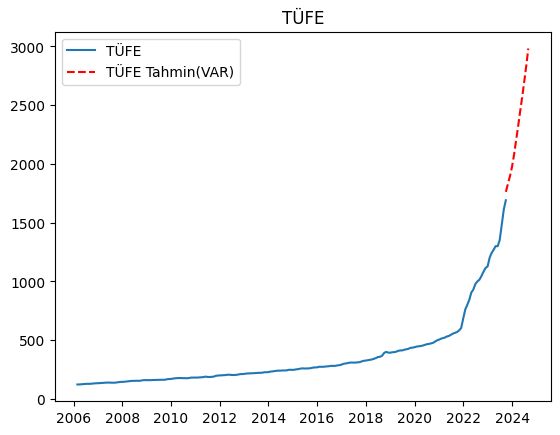

In [545]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

model = sm.tsa.VAR(data)
# Modeli uyarlayın
results = model.fit(ic="bic",maxlags=3)  # İhtiyaca göre maksimum gecikme düzeyini ayarlayabilirsiniz

# Tahminler yapın (örneğin, 12 aylık öngörü)
forecast_horizon = 12
forecast = results.forecast(y=results.endog, steps=forecast_horizon)

forecast=pd.DataFrame(forecast[:,4])
forecast.columns=["TÜFE"]
forecast=forecast.set_index(pd.date_range('2023-10-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
plt.plot(df["CPI"],label="TÜFE")
plt.plot(forecast,"--",label="TÜFE Tahmin(VAR)",color="red")
plt.title("TÜFE")
plt.legend()




In [546]:
results.aic

-0.5761945372680216

In [547]:
dates=pd.date_range('2023-10-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin5=pd.DataFrame(forecast["TÜFE"])
tahmin5=tahmin5.set_index(dates)
tahmin5.columns=["TÜFE"]
tahmin5

,TÜFE
2023-10-01,1762.837083
2023-11-01,1831.833477
2023-12-01,1895.113083
2024-01-01,1975.655839
2024-02-01,2080.817089
2024-03-01,2196.901111
2024-04-01,2318.482899
2024-05-01,2443.381103
2024-06-01,2568.216072
2024-07-01,2695.941291


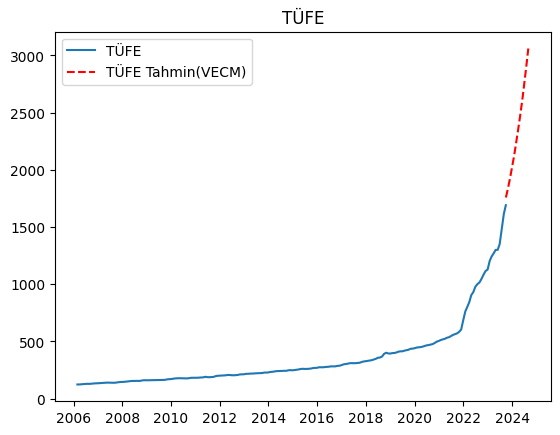

In [548]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm
data=pd.DataFrame()
dates=pd.date_range(start='2006-02-01', periods=212, freq='M')

# Veriyi bir veri çerçevesine yerleştirme
data["USD/TL"]=df6["USD/TL"].rolling(3).mean().dropna()
data["Para Arzı"]=money["Para Arzi Onceki"]
data["Brent"]=df14["Brent"]
data["Kredi"]=df3["Kredi"]
data["TÜFE"]=df["CPI"]




model = sm.VECM(data, k_ar_diff=1, coint_rank=5, deterministic="co",seasons=12)
results = model.fit()

# TÜFE'nin gelecekteki değerlerini tahmin et
tahmin = results.predict(steps=12, alpha=0.05)

tahmin1=pd.DataFrame(tahmin[0],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE'])


tahmin2=pd.DataFrame(tahmin[1],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE'])
tahmin3=pd.DataFrame(tahmin[2],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE'])

tahmin4=pd.DataFrame()
tahmin4["TÜFE"]=(tahmin1["TÜFE"]+tahmin2["TÜFE"]+tahmin3["TÜFE"])/3
dates=pd.date_range('2023-10-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin4=tahmin4.set_index(dates)
plt.plot(df["CPI"],label="TÜFE")
plt.plot(tahmin4,"--",label="TÜFE Tahmin(VECM)",color="red")
plt.title("TÜFE")
plt.legend()

In [549]:
dff=pd.concat([df["CPI"].head(212),df9["TÜFE"]],axis=0)
dff=pd.DataFrame(dff)
dff.columns=["CPI"]



dfas4=pd.concat([df["CPI"].head(212),tahmin4["TÜFE"]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=["CPI"]

dfas5=pd.concat([df["CPI"].head(212),tahmin5["TÜFE"]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=["CPI"]











In [550]:
import pandas as pd

# Örnek DataFrame oluşturalım (gerçek verilere göre değiştirin)
# Diyelim ki veriler 'tufe' sütununda ve 'tarih' sütununda saklanıyor




# 12 ay önceki tüfe değerlerini içeren bir sütun ekleyin
dff['onceki_yil_tufe'] = dff['CPI'].shift(12)
dfas4['onceki_yil_tufe'] = dfas4['CPI'].shift(12)
dfas5['onceki_yil_tufe'] = dfas5['CPI'].shift(12)



# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
dff['yillik_enflasyon_orani'] = ((dff['CPI'] / dff['onceki_yil_tufe']) - 1) * 100
dfas4['yillik_enflasyon_orani'] = ((dfas4['CPI'] / dfas4['onceki_yil_tufe']) - 1) * 100
dfas5['yillik_enflasyon_orani'] = ((dfas5['CPI'] / dfas5['onceki_yil_tufe']) - 1) * 100

# NaN değerleri (ilk 12 ay) veriden çıkarın
dff.dropna(inplace=True)
dfas4.dropna(inplace=True)
dfas5.dropna(inplace=True)





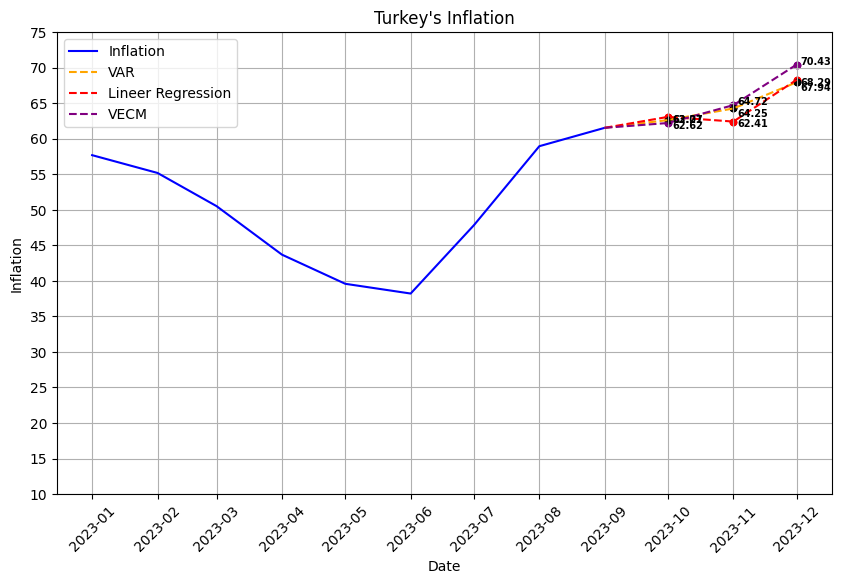

In [551]:
dates=pd.date_range('2007-02-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
dff=dff.set_index(dates)
dfas4=dfas4.set_index(dates)
dfas5=dfas5.set_index(dates)







# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(dff.iloc[191:200]["yillik_enflasyon_orani"], label='Inflation', color='blue')
#plt.plot(dfas2.iloc[198:203]["yillik_enflasyon_orani"],'--', label='Forecast with monetary tightening', color='green')
plt.plot(dfas5.iloc[199:203]["yillik_enflasyon_orani"],'--',label='VAR', color='orange')
plt.plot(dff.iloc[199:203]["yillik_enflasyon_orani"],'--',label='Lineer Regression', color='red')
plt.plot(dfas4.iloc[199:203]["yillik_enflasyon_orani"],'--',label='VECM', color='purple')



plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dff.iloc[191:].index, dff.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = int(max(dff["yillik_enflasyon_orani"].iloc[191:]))
y_min = 10
y_interval = 0.5
y_ticks = [y_min]
while y_ticks[-1] < y_max:
    y_ticks.append(y_ticks[-1] + 5)

son_dort_veri=dff["yillik_enflasyon_orani"].iloc[200:203]
son_dort_veri3=dfas4["yillik_enflasyon_orani"].iloc[200:203]
son_dort_veri4=dfas5["yillik_enflasyon_orani"].iloc[200:203]



# Y ekseni etiketlerini ayarlama
for i, v in enumerate(son_dort_veri):
    plt.annotate(f'{v:.2f}', (son_dort_veri.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri.index,son_dort_veri,color='red',s=20)


for i, v in enumerate(son_dort_veri3):
    plt.annotate(f'{v:.2f}', (son_dort_veri3.index[i], v), xytext=(3, 0), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri3.index,son_dort_veri3,color='purple',s=20)

for i,v in enumerate(son_dort_veri4):
    plt.annotate(f'{v:.2f}', (son_dort_veri4.index[i], v), xytext=(3, -6), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri4.index,son_dort_veri4,color='black',s=20)



#for i,v in enumerate(son_dort_veri6):
 #   plt.annotate(f'{v:.2f}', (son_dort_veri5.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
  #               color='black', fontweight='bold')
   # plt.scatter(son_dort_veri6.index,son_dort_veri6,color='green',s=20)






# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()


#VAR ve VECM modelleri neredeyse aynı tahmini yaptığından üst üste gelmiş olarak gözüküyor.

In [552]:
lineer_regression=(((dff.loc['2023-10-01']["CPI"]/dff.loc['2023-09-01']["CPI"])-1)*100)
var=(((dfas5.loc['2023-10-01']["CPI"]/dfas5.loc['2023-09-01']["CPI"])-1)*100)
vecm=(((dfas4.loc['2023-10-01']["CPI"]/dfas4.loc['2023-09-01']["CPI"])-1)*100)
ortalama=(lineer_regression+var+vecm)/3







In [553]:
lineer_regression_yillik=(((dff.loc['2023-12-01']["CPI"]/dff.loc['2022-12-01']["CPI"])-1)*100)
var_yillik=(((dfas5.loc['2023-12-01']["CPI"]/dfas5.loc['2022-12-01']["CPI"])-1)*100)
vecm_yillik=(((dfas4.loc['2023-12-01']["CPI"]/dfas4.loc['2022-12-01']["CPI"])-1)*100)
ortalama_yillik=(lineer_regression_yillik+var_yillik+vecm_yillik)/3



In [554]:
tahminler=pd.DataFrame({"Ekim 2023(Aylık)":[lineer_regression,var,vecm,ortalama],"Yıl Sonu":[lineer_regression_yillik,var_yillik,vecm_yillik,ortalama_yillik]},index=["Lineer Regression","VAR","VECM","Ortalama"])
tahminler



,Ekim 2023(Aylık),Yıl Sonu
Lineer Regression,4.531522,68.291065
VAR,4.245735,67.939482
VECM,3.978966,70.430744
Ortalama,4.252075,68.887097
